In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from UKMovementSensing import hsmm

import pandas as pd
import numpy as np

In [18]:
execfile('config.py')

## Load the data

In [16]:
filenames = os.listdir(train_path)[0:1]
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(train_path,fn))]
datasets = [pd.read_csv(os.path.join(train_path,fn)) for fn in filenames]
print(len(datasets))

1


In [6]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 

In [17]:
# Take one example datset and have a look
example_index = 0
example_data = datasets[example_index]

example_data.head()

,timestamp,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,dev_roll_med_acc_z,invalid,heuristic,filename,subset,switched_pos,start_time,activity,label
0,2015-03-14T04:00:00+0000,0.003508,1.000189,-16.553190,2.185656,73.294853,-0.284975,0.038147,0.958031,0.000902,-0.000703,0.000199,0,2,__022454_2015-03-20 14-34-22.bin_day2.csv,0,False,2015-03-14T04:00:00+0000,1,Sleeping and resting (including sick in bed)
1,2015-03-14T04:00:05+0000,0.003717,1.001319,-16.472146,2.122872,73.383549,-0.284151,0.037122,0.960277,-0.000177,-0.000382,-0.000914,0,2,__022454_2015-03-20 14-34-22.bin_day2.csv,0,False,2015-03-14T04:00:00+0000,1,Sleeping and resting (including sick in bed)
2,2015-03-14T04:00:10+0000,0.003193,0.999808,-16.531781,1.979577,73.343174,-0.284445,0.034531,0.957693,0.000765,0.001728,0.000298,0,2,__022454_2015-03-20 14-34-22.bin_day2.csv,0,False,2015-03-14T04:00:00+0000,1,Sleeping and resting (including sick in bed)
3,2015-03-14T04:00:15+0000,0.003372,1.000583,-16.552827,2.028836,73.315788,-0.284837,0.035395,0.957693,0.000589,0.000522,0.000954,0,2,__022454_2015-03-20 14-34-22.bin_day2.csv,0,False,2015-03-14T04:00:00+0000,1,Sleeping and resting (including sick in bed)
4,2015-03-14T04:00:20+0000,0.003506,0.999979,-16.562374,1.956356,73.315831,-0.284997,0.034131,0.957693,0.001139,0.001767,0.000437,0,2,__022454_2015-03-20 14-34-22.bin_day2.csv,0,False,2015-03-14T04:00:00+0000,1,Sleeping and resting (including sick in bed)


## Prepare data for HSMM

In [9]:
X_list = [d[column_names].as_matrix() for d in datasets]

## Train HSMM

0
Resampled 1 sequences in 3.2 seconds
Log likelihood:  33861.0243783


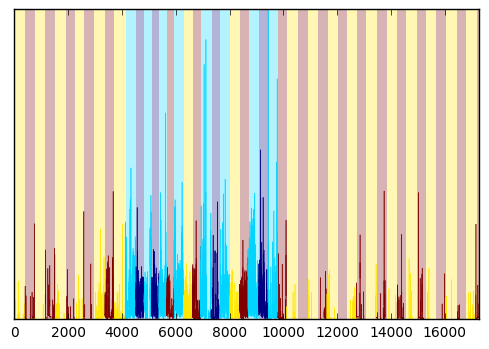

Convergence: average Hamming distance is 0.597569444444
1
Resampled 1 sequences in 3.1 seconds
Log likelihood:  41498.5107593


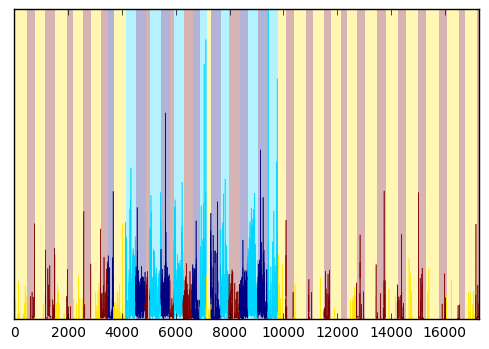

Convergence: average Hamming distance is 0.297395833333
2
Resampled 1 sequences in 3.1 seconds
Log likelihood:  42913.6942896


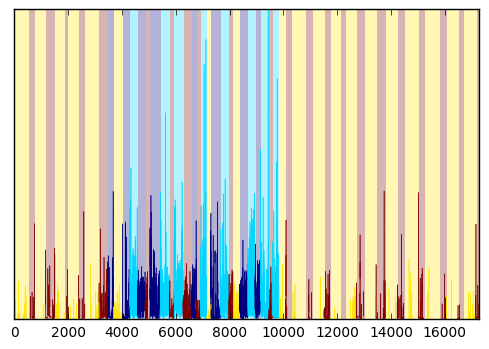

Convergence: average Hamming distance is 0.184780092593
3
Resampled 1 sequences in 3.0 seconds
Log likelihood:  43766.2546091


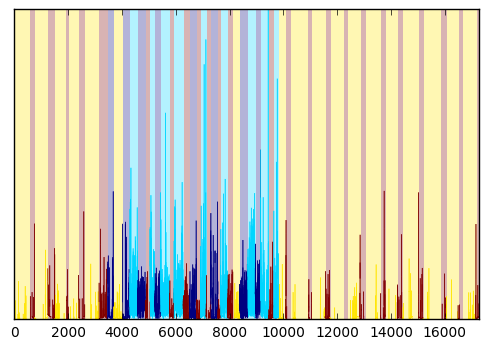

Convergence: average Hamming distance is 0.0961226851852
4
Resampled 1 sequences in 3.0 seconds
Log likelihood:  44094.3343346


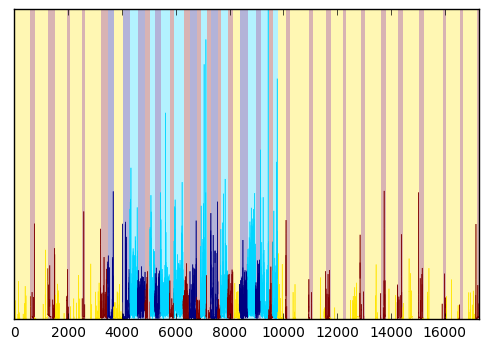

Convergence: average Hamming distance is 0.0433449074074


In [12]:
#Note that with many iterations, the visualization becomes badly visible
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=nr_resamples, trunc=truncate, visualize=True, example_index=example_index)

## Plot one example

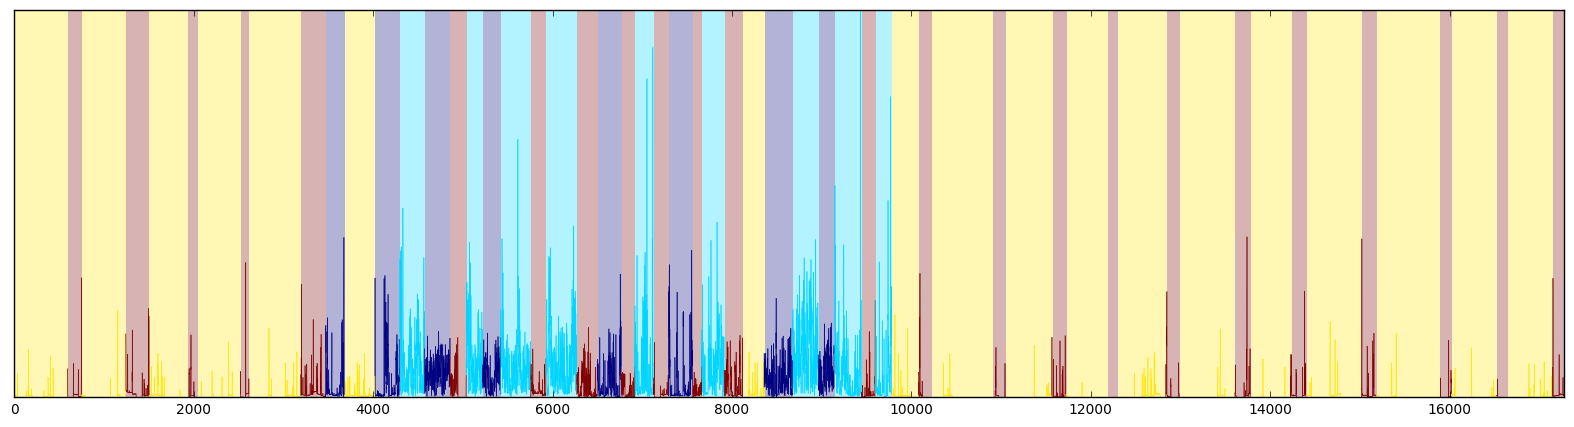

In [19]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 5))
model.plot_stateseq(example_index)

## Save the data with the states

Save the data including the states found. This labeled data serves as an input to the analyses.

In [20]:
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])+'.csv'
    dat.to_csv(os.path.join(states_path, fn))

## Save the model

NB: This removes the data from the model! Only run this if you've saved the data with states.

In [21]:
import pickle
#Remove the data from the model
model.states_list = []

with open(model_file, 'wb') as f:
    pickle.dump(model, file=f)

## Save the config

In [24]:
from shutil import copyfile

if not os.path.exists(config_path):
    os.makedirs(config_path)
copyfile('config.py', config_file)

## Possibly: Apply the model to new data